In [1]:
import sys
sys.path.append('/Users/eran/Dropbox/ASU/SINE/python/')
from my_functions import db_engine
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
eng = db_engine()

Inputs

In [26]:
# criteria = 'rms'
candidates = 20 #filter to the best x candiadates

Get Data for voltage and angle evaluation at the specified criteria

In [27]:
sql = ("SELECT b.idint as id, a.caseid as case, a.value FROM linpf.vt a INNER JOIN linpf.idmap b ON a.id=b.id "
       "WHERE a.prop=%(prop)s and a.criteria=%(criteria)s "
       "ORDER BY b.id, a.caseid")
# df  = {}
# for i in ['vol', 'ang']:
#     df[i] = pd.read_sql_query(sql,eng,params={'prop': i, 'criteria': criteria})

## Threshold to a few candidates
We align the data into a table with the id's as rows, the cases as columns and the value of the criteria as content.
The maximum value for each *id*, $d$, for each property, $x$, is calculated and these are sorted.
A threshold is decided by selecting the value of the $candidate$-th entry in the sorted list of maximum values.
This way when we filter, we'll have at least that many ids.
The data is now filtered using the threshold.

In [86]:
df3 = {}; stats = {}; best = {}; df_cross = {}
for crit in ['rms', 'max', 'avg', 'del', 'cor']:
    df  = {}
    for i in ['vol', 'ang']:
        df[i] = pd.read_sql_query(sql,eng,params={'prop': i, 'criteria': crit})

    df2 = {}
    for i in ['vol', 'ang']:
        df2[i] = df[i].pivot(index='id', columns='case', values='value')

    threshold = {}
    for i in ['vol','ang']:
        if crit == 'cor':
            threshold[i]= np.sort( df2[i].min(axis=1))[-candidates]
        else:
            threshold[i] = np.sort( df2[i].max(axis=1))[candidates-1]
    df3[crit] = {}
    for i in ['vol','ang']:
        if crit == 'cor':
            df3[crit][i] = df[i].loc[df[i]['value'] >= threshold[i], :].pivot(index='id', columns='case', values='value')
        else:
            df3[crit][i] = df[i].loc[df[i]['value'] <= threshold[i], :].pivot(index='id', columns='case', values='value')
        
        df3[crit][i] = df3[crit][i].loc[df3[crit][i].notnull().all(axis=1),:]

    ### summary statistics
    stats[crit] = {}
    for i in ['vol','ang']:
        stats[crit][i] = pd.DataFrame(index=df3[crit][i].index, columns=['mean','median', 'std', 'max', 'min'], 
                               data=np.hstack([df3[crit][i].mean(axis=1).values[:,np.newaxis], 
                                               df3[crit][i].median(axis=1).values[:, np.newaxis],
                                               df3[crit][i].std(axis=1).values[:, np.newaxis],
                                               df3[crit][i].max(axis=1).values[:, np.newaxis],
                                               df3[crit][i].min(axis=1).values[:, np.newaxis]]))
    ### best ids
    if crit == 'cor':
        best[crit] = pd.concat([ pd.concat([stats['cor'][i].loc[:,['mean', 'median', 'max', 'min']].idxmax(axis=0), 
                                 pd.Series(data=stats['cor'][i].loc[:,'std'].idxmin(axis=0), index=['std'])]) for i in ['vol', 'ang']],
                               axis=1).rename(columns={0:'vol', 1:'ang'})
    else:
        best[crit] = pd.concat([stats[crit][i].idxmin(axis=0) for i in ['vol', 'ang']], axis=1).rename(columns={0:'vol', 1:'ang'})
    
    best_ids = best[crit].values.flatten()

    ### comparison between ids
    df_cross[crit] = {}
    for i in ['vol', 'ang']:
        df_cross[crit][i] = df[i].loc[ df[i]['id'].isin(best_ids),:].pivot(index='id', columns='case', values='value')
        df_cross[crit][i + '_stats'] = pd.DataFrame(index=df_cross[crit][i].index, columns=['mean','median', 'std', 'max', 'min'], 
                       data=np.hstack([df_cross[crit][i].mean(axis=1).values[:,np.newaxis], 
                                       df_cross[crit][i].median(axis=1).values[:, np.newaxis],
                                       df_cross[crit][i].std(axis=1).values[:, np.newaxis],
                                       df_cross[crit][i].max(axis=1).values[:, np.newaxis],
                                       df_cross[crit][i].min(axis=1).values[:, np.newaxis]]))

In [176]:
best_ids = np.concatenate([best[crit].values.flatten() for crit in best] )
best_ids = np.append(best_ids, 1737) #1737 corresponds to the id in Zhigang's paper

sql = ("SELECT b.idint as id, a.caseid as case, a.value FROM linpf.vt a INNER JOIN linpf.idmap b ON a.id=b.id "
       "WHERE a.prop=%(prop)s and a.criteria=%(criteria)s and b.idint in %(ids)s "
       "ORDER BY b.id, a.caseid")
df_full    ={}
stats_full = {}
for crit in ['rms', 'max', 'avg', 'del', 'cor']:
    df_full[crit]  = {}
    for i in ['vol', 'ang']:
        df_full[crit][i] = pd.read_sql_query(sql,eng,
                params={'prop': i, 'criteria': crit, 'ids': tuple(int(j) for j in best_ids) }).pivot(index='id', columns='case', values='value')
    stats_full[crit] = {}
    for i in ['vol', 'ang']:
        stats_full[crit][i] = pd.DataFrame(index=df_full[crit][i].index, columns=['mean','median', 'std', 'max', 'min'], 
                               data=np.hstack([df_full[crit][i].mean(axis=1).values[:,np.newaxis], 
                                               df_full[crit][i].median(axis=1).values[:, np.newaxis],
                                               df_full[crit][i].std(axis=1).values[:, np.newaxis],
                                               df_full[crit][i].max(axis=1).values[:, np.newaxis],
                                               df_full[crit][i].min(axis=1).values[:, np.newaxis]]))

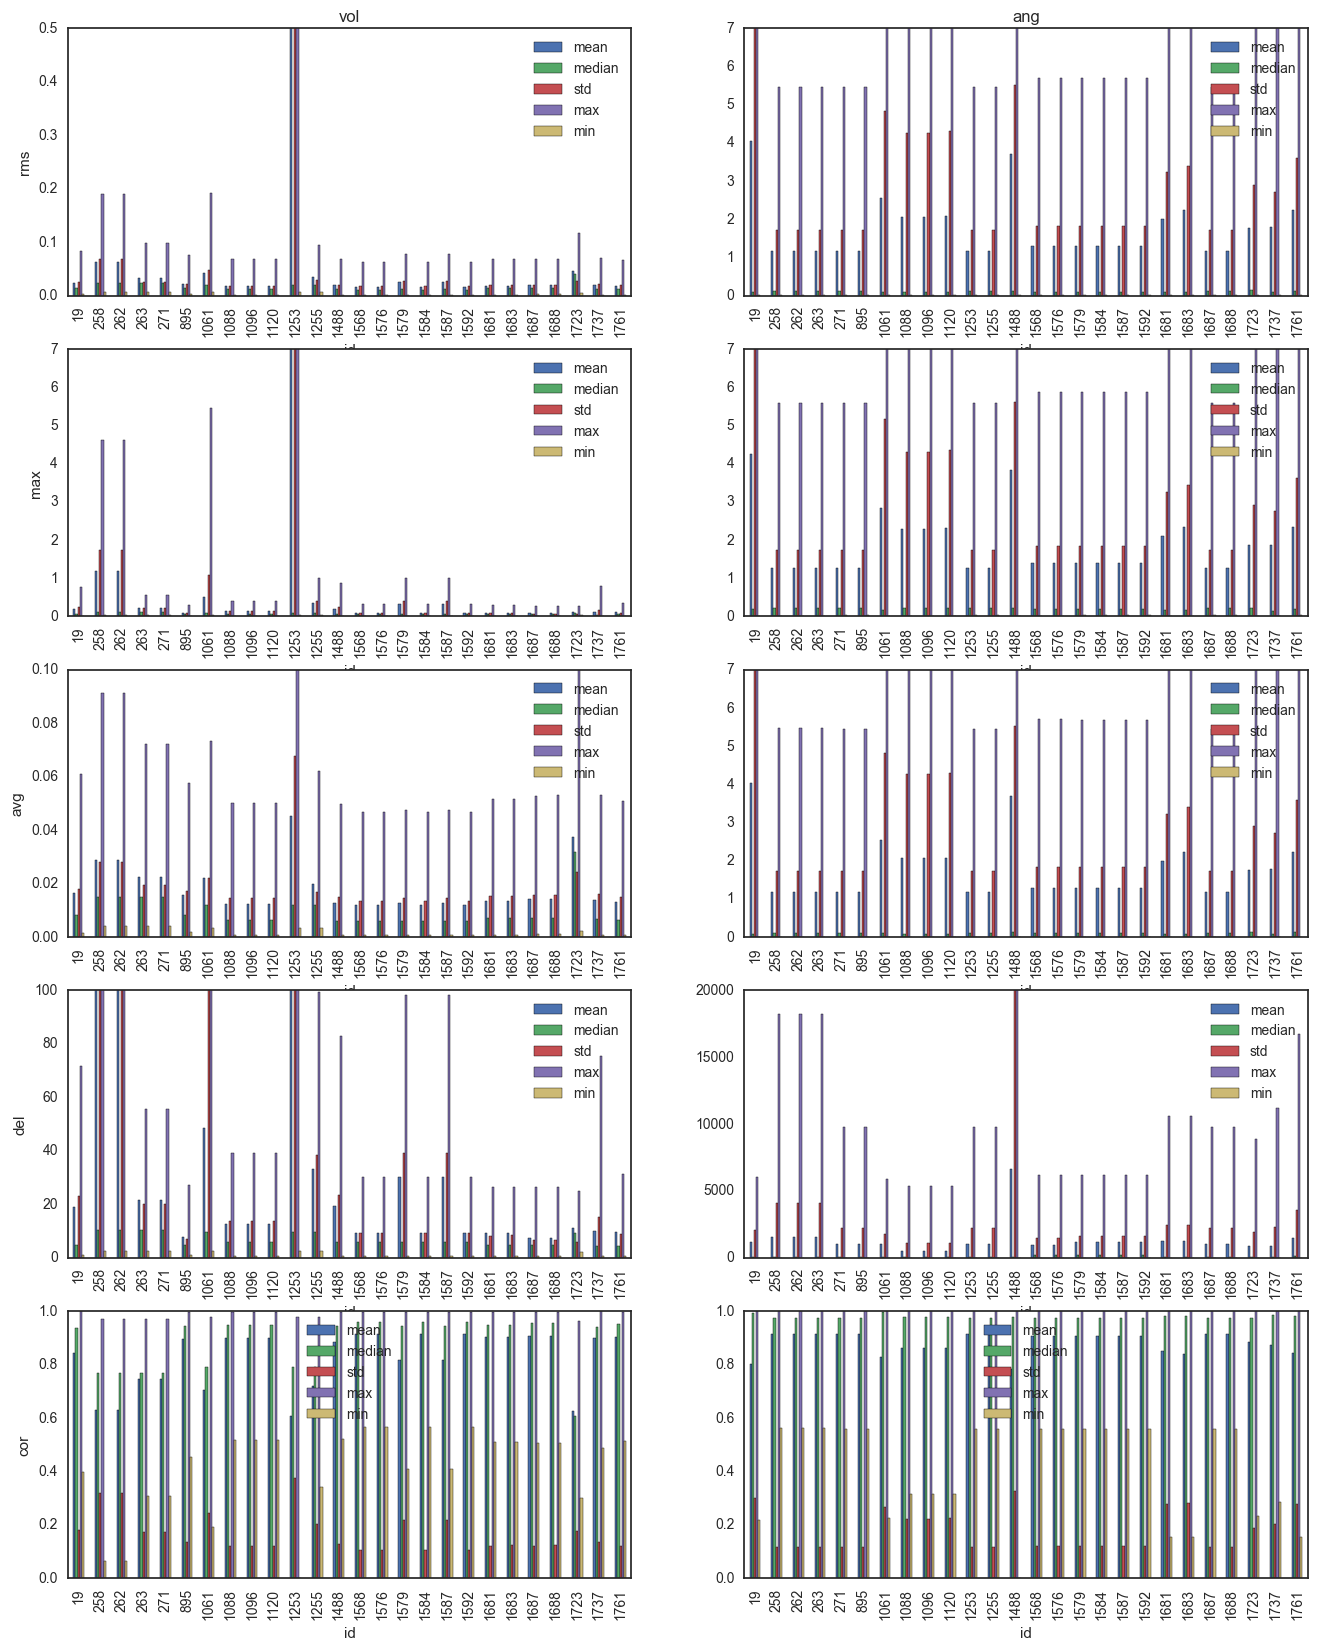

In [178]:
fig, ax = plt.subplots(5, 2, figsize=(16,20))
limits = {}
limits['vol'] = {'rms': 0.5, 'max': 7, 'avg': 0.1, 'del': 100, 'cor': 0}
limits['ang'] = {'rms': 7, 'max': 7, 'avg': 7, 'del': 20e3, 'cor': 0}
for i, crit in enumerate(['rms', 'max', 'avg', 'del', 'cor']): 
    for j, k in enumerate(['vol', 'ang']):
        stats_full[crit][k].plot(kind='bar', ax=ax[i,j])
        if crit == 'cor':
            ax[i,j].set_ylim([limits[k][crit], 1])
        else:
            ax[i,j].set_ylim([0, limits[k][crit]])
        if i == 0:
            ax[i,j].set_title(k)
        if j == 0:
            ax[i,j].set_ylabel(crit)
plt.show()

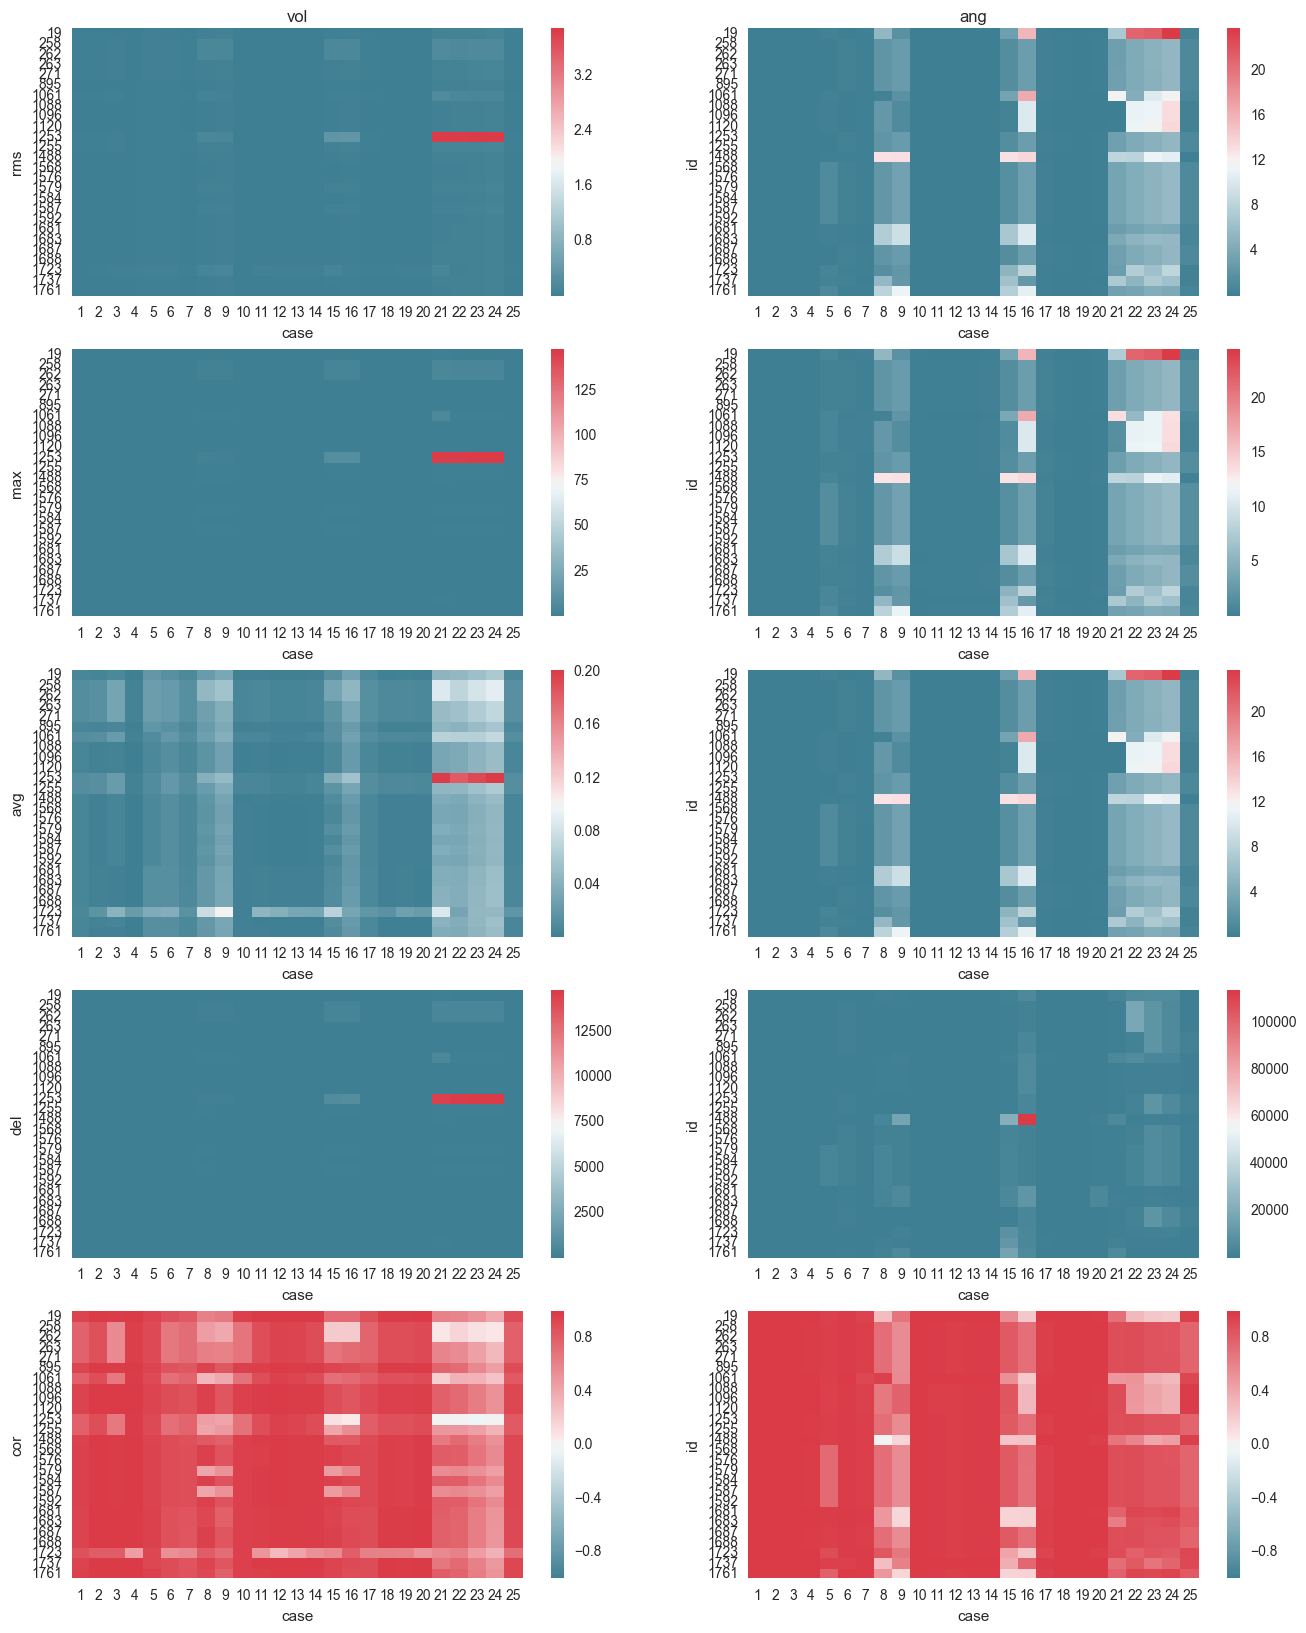

In [179]:
fig, ax = plt.subplots(5, 2, figsize=(16,20))
for i, crit in enumerate(['rms', 'max', 'avg', 'del', 'cor']): 
    for j, k in enumerate(['vol', 'ang']):
        sns.heatmap(df_full[crit][k], cmap=cmap, ax=ax[i,j])
        if i == 0:
            ax[i,j].set_title(k)
        if j == 0:
            ax[i,j].set_ylabel(crit)
plt.show()

We want to normalize the scores w.r.t each criteria so that it is between 0 and 1. 
\begin{equation}
    x_{pu} = \frac{x - x_{\text{min}}}{ x_{\text{max}} - x_{\text{min}} }
\end{equation}

one way to select the best for a givne property ($v$ or $\theta$) is
\begin{equation} 
    \sum\limits_{s\neq \text{cor}}\sum\limits_{c\in C} d(s,c) -  \sum\limits_{c\in C} d(\text{cor}, c)
\end{equation}

In [180]:
df_scaled = {}
for i, crit in enumerate(['rms', 'max', 'avg', 'del', 'cor']): 
    df_scaled[crit] = {}
    for j, k in enumerate(['vol', 'ang']):
        xmax = df_full[crit][k].values.flatten().max()
        xmin = df_full[crit][k].values.flatten().min()
        df_scaled[crit][k] = (df_full[crit][k] - xmin)/(xmax-xmin)


In [181]:
score = {}
for k in ['vol', 'ang']:
    score[k] = pd.Series(index=df_scaled['rms']['vol'].index,data= 0)
for crit in ['rms', 'max', 'avg', 'del', 'cor']: 
    for k in ['vol', 'ang']: 
        if crit == 'cor':
            score[k] -= df_scaled[crit][k].sum(axis=1)
        else:
            score[k] += df_scaled[crit][k].sum(axis=1)

In [182]:
score['vol'].sort_values()

id
1584   -21.466197
1592   -21.466171
1568   -21.463356
1576   -21.463323
1761   -21.028672
1096   -20.990448
1088   -20.990438
1120   -20.988523
1687   -20.942382
1688   -20.921897
1681   -20.906804
1683   -20.889050
1737   -20.823562
1488   -20.536804
895    -20.409212
19     -19.097090
1579   -18.834247
1587   -18.834136
271    -15.854713
263    -15.854713
1255   -15.568136
1061   -14.801890
258    -11.818818
262    -11.818334
1723   -11.114068
1253     2.507200
dtype: float64

In [183]:
(score['vol'] + score['ang']).sort_values()

id
1687   -39.864362
1688   -39.843877
1568   -39.775783
1576   -39.775548
1584   -39.716132
1592   -39.715101
895    -39.331192
1579   -37.084182
1587   -37.083065
1737   -36.819284
1096   -35.796557
1088   -35.795684
1120   -35.732051
1681   -35.572833
271    -34.776373
1761   -34.715591
263    -34.676185
1683   -34.527817
1255   -34.489796
258    -30.640256
262    -30.639805
1723   -27.492965
1061   -27.082820
1488   -27.034276
19     -26.124602
1253   -16.414460
dtype: float64

## Heat maps
The hit maps give a feel for how the given critera fairs both with respect to the ids, as well as the different cases.
Fairly solid looking vertical bars suggests that the ids perform similarly for a given case.

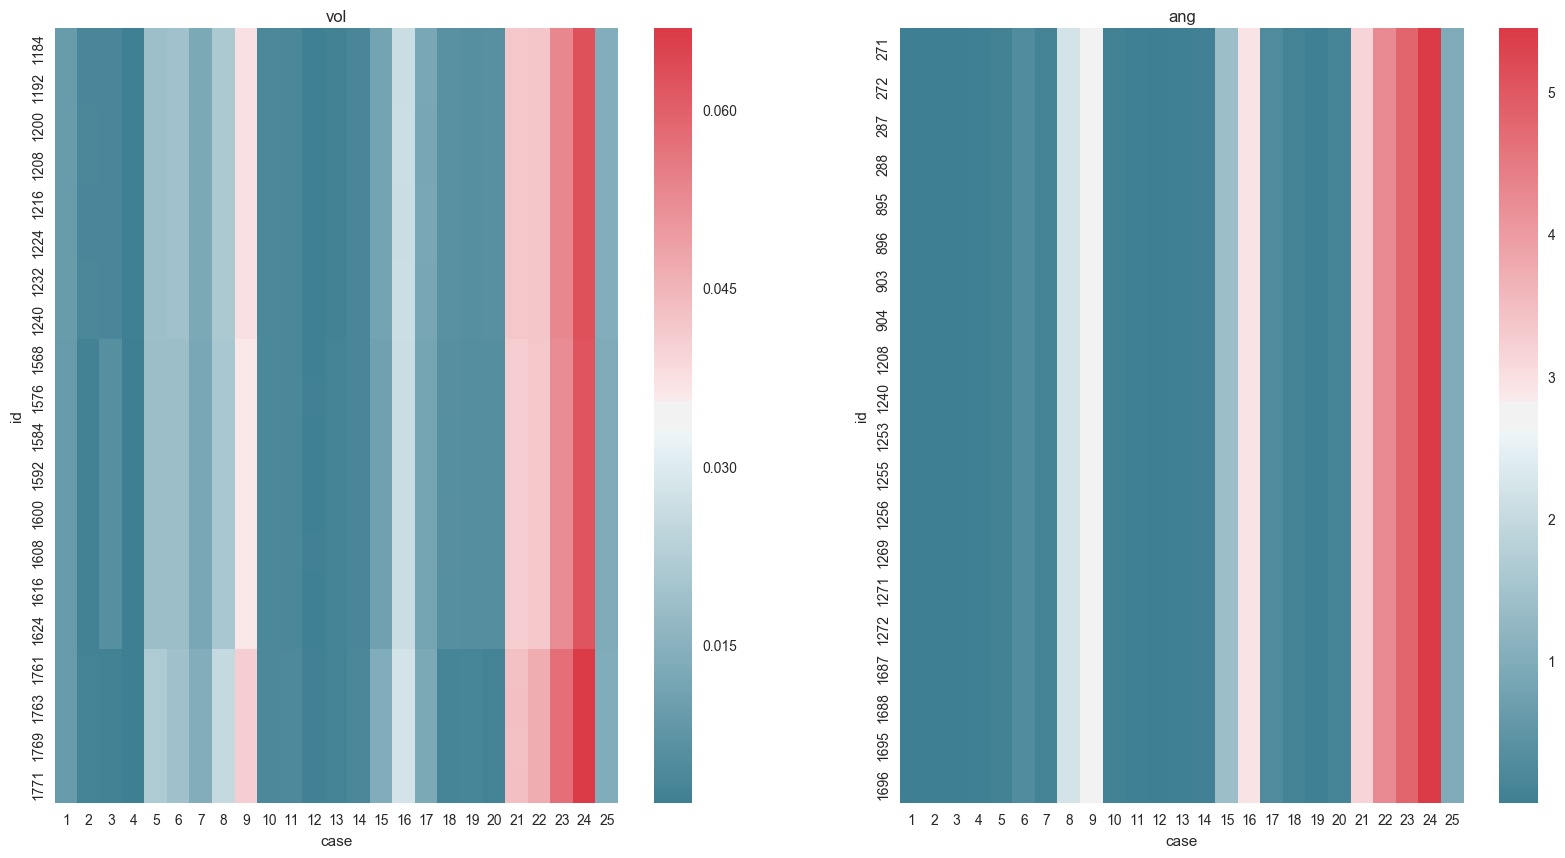

In [18]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
for i, k in enumerate(['vol', 'ang']):
    sns.heatmap(df3[k], cmap=cmap, ax=ax[i])
    ax[i].set_title(k)
# sns.heatmap(dfv3,cmap=cmap, ax=ax[0])
# sns.heatmap(dfa3,cmap=cmap, ax=ax[1])
# ax[0].set_title('vol')
# ax[1].set_title('ang')
plt.show()

## Basic Statistics
We consider some basic statistics accross the cases. 
This helps further visualize the "cost" of picking one id over the other

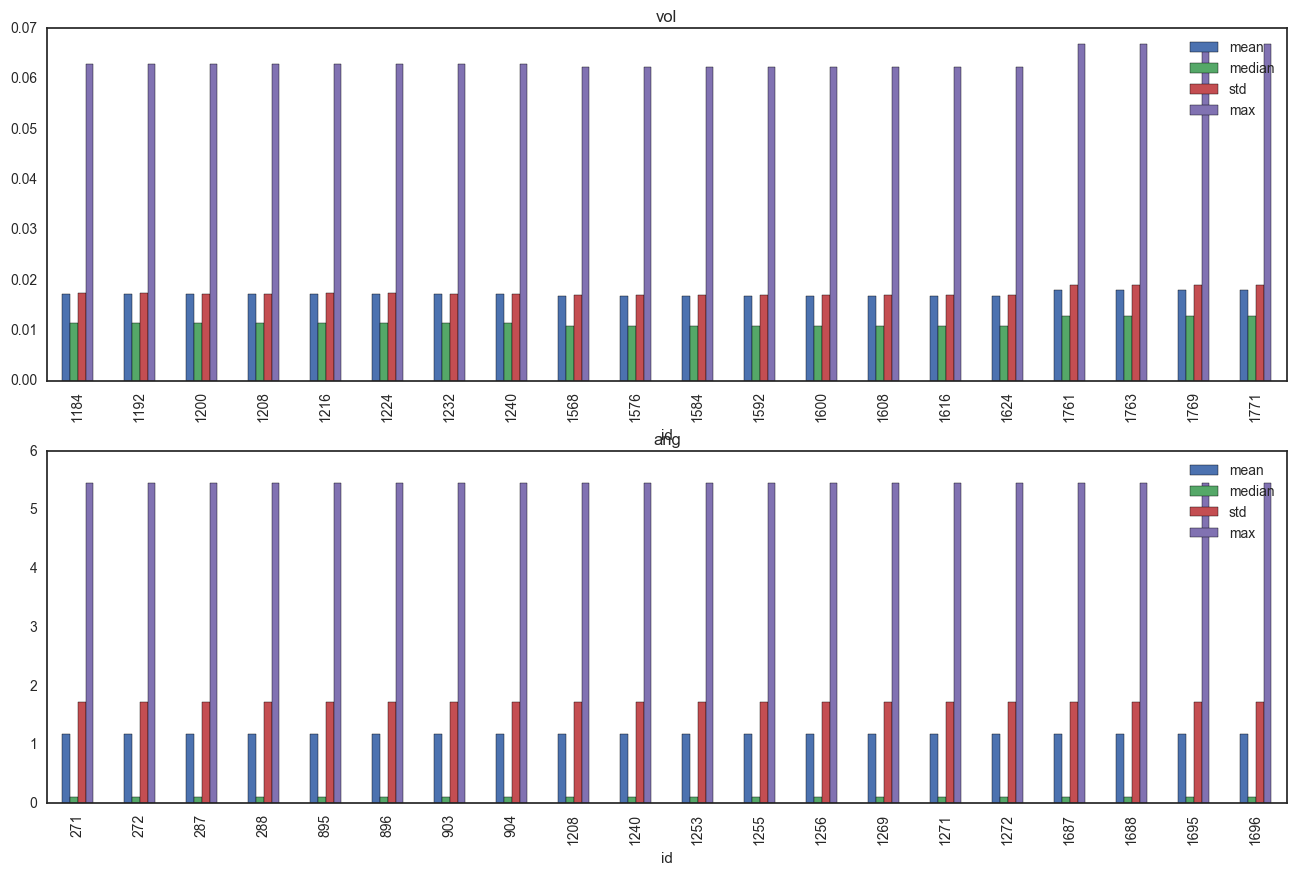

In [19]:
fig, ax = plt.subplots(2,1, figsize=(16,10))
# df3.mean(axis=1).plot(ax=ax[0],kind='line',label='mean')
# tmpv = pd.DataFrame(index=dfv3.index, columns=['mean','median', 'std', 'max'], 
#                    data=np.hstack([dfv3.mean(axis=1).values[:,np.newaxis], 
#                                    dfv3.median(axis=1).values[:, np.newaxis],
#                                    dfv3.std(axis=1).values[:, np.newaxis],
#                                    dfv3.max(axis=1).values[:, np.newaxis]]))
# tmpa = pd.DataFrame(index=dfa3.index, columns=['mean','median', 'std', 'max'], 
#                    data=np.hstack([dfa3.mean(axis=1).values[:,np.newaxis], 
#                                    dfa3.median(axis=1).values[:, np.newaxis],
#                                    dfa3.std(axis=1).values[:, np.newaxis],
#                                    dfa3.max(axis=1).values[:, np.newaxis]]))
for i, k in enumerate(['vol', 'ang']):
    stats[k].plot(kind='bar', ax=ax[i])
    ax[i].set_title(k)
# tmpv.plot(kind='bar', ax=ax[0])
# tmpa.plot(kind='bar', ax=ax[1])
# ax[0].set_title('vol')
# ax[1].set_title('ang')
plt.show()

## Index of best performace
Finally, we look at which index performed best for each summary statistic.

In [30]:
df_best = pd.concat([tmpv.idxmin(axis=0),tmpa.idxmin(axis=0)], axis=1).rename(columns={0:'vol', 1:'ang'})
df_best

,vol,ang
mean,1592,1255
median,1568,271
std,1592,1688
max,1592,1688


## Cross comparison
The next step is to consider the set of *best indecies* and how the perform for all the different caes.

In [39]:
best_ids = df_best.values.flatten()
df_cross = {}
df_cross['vol'] = dfv.loc[ dfv['id'].isin(best_ids), :].pivot(index='id', columns='case', values='value')
df_cross['ang'] = dfa.loc[ dfa['id'].isin(best_ids), :].pivot(index='id', columns='case', values='value')

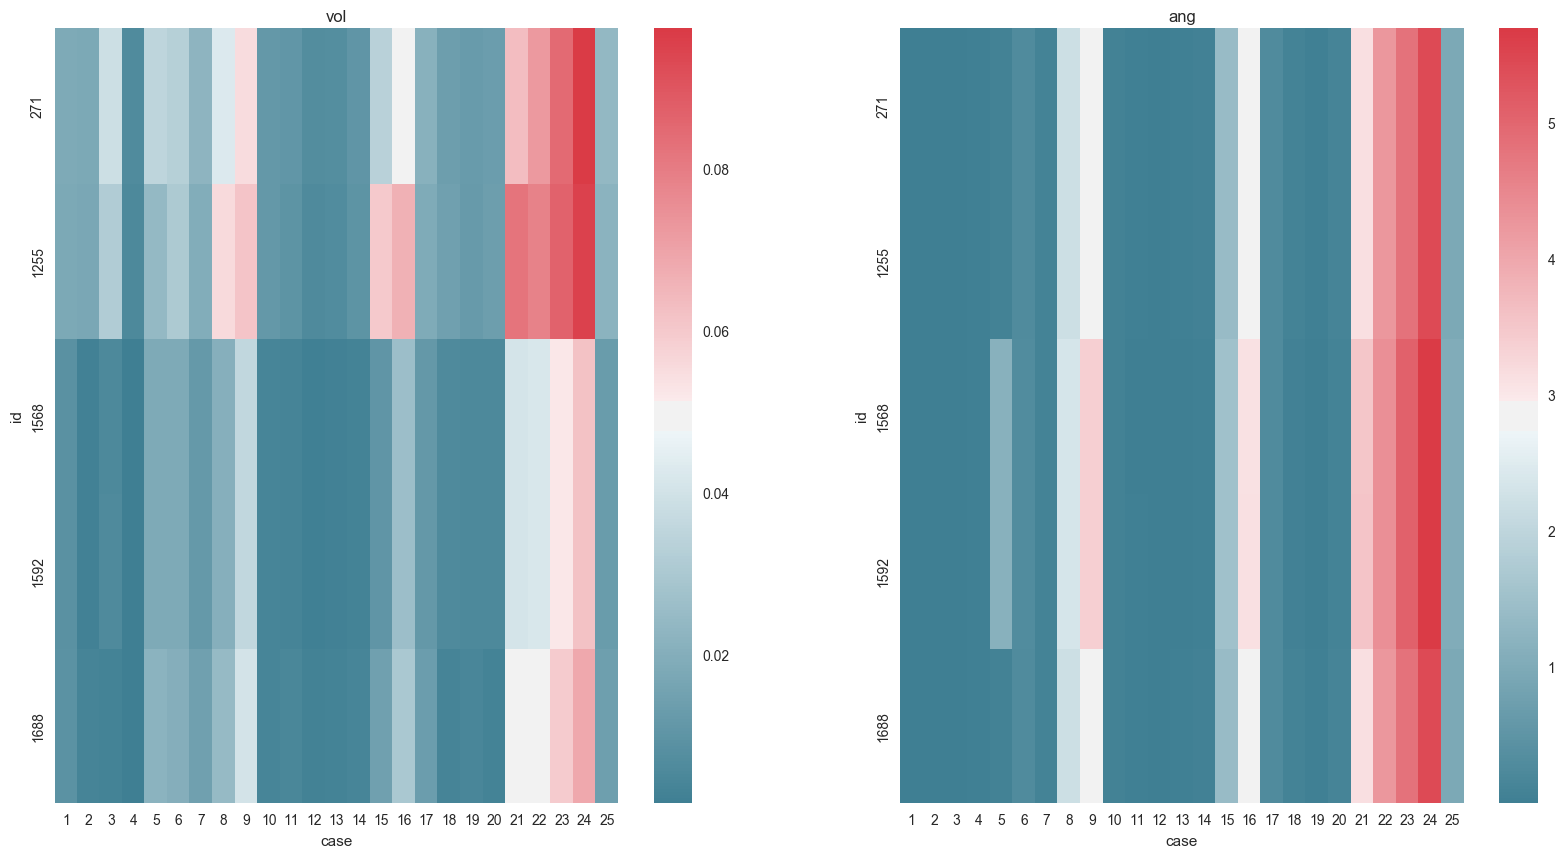

In [20]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
for i, s in enumerate(['vol', 'ang']):
    sns.heatmap(df_cross[s],cmap=cmap, ax=ax[i])
    ax[i].set_title(s)
plt.show()

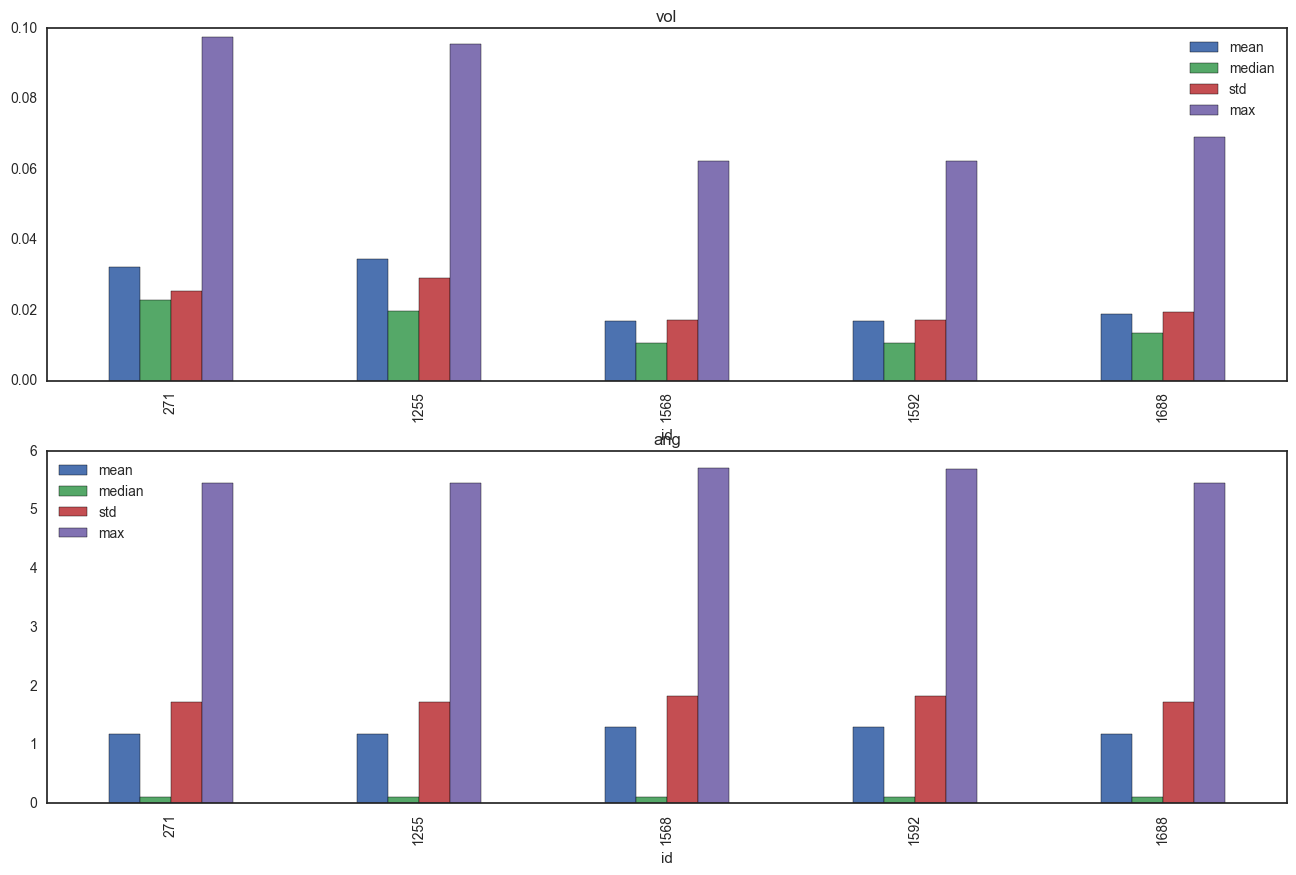

In [21]:
fig, ax = plt.subplots(2,1, figsize=(16,10))
for i, s in enumerate(['vol', 'ang']):
    df_cross[s + '_stats'] = pd.DataFrame(index=df_cross[s].index, columns=['mean','median', 'std', 'max'], 
                   data=np.hstack([df_cross[s].mean(axis=1).values[:,np.newaxis], 
                                   df_cross[s].median(axis=1).values[:, np.newaxis],
                                   df_cross[s].std(axis=1).values[:, np.newaxis],
                                   df_cross[s].max(axis=1).values[:, np.newaxis]]))
    df_cross[s + '_stats'].plot(kind='bar', ax=ax[i])
    ax[i].set_title(s)
plt.show()